In [3]:
library(tidyverse)
library(parameters)
library(lme4)
library(lmerTest)
library(nlme)
options(width = 150)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: 

# correlation between community traits and environmental factors

In [4]:
total_fit <- read_csv('all_fit_env.csv')

Rows: 19664 Columns: 38
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): term.maxLengthTL, dataset_name.maxLengthTL, dataset_grid.maxLengthTL, term.Troph, dataset_name.Troph, dataset_grid.Troph, term.tempPref,...
dbl (29): grid, estimate.maxLengthTL, std.error.maxLengthTL, statistic.maxLengthTL, p.value.maxLengthTL, max_year.maxLengthTL, min_year.maxLengthT...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
colnames(total_fit)

[1] "grid"                     "term.maxLengthTL"         "estimate.maxLengthTL"     "std.error.maxLengthTL"    "statistic.maxLengthTL"   
 [6] "p.value.maxLengthTL"      "dataset_name.maxLengthTL" "max_year.maxLengthTL"     "min_year.maxLengthTL"     "dataset_grid.maxLengthTL"
[11] "term.Troph"               "estimate.Troph"           "std.error.Troph"          "statistic.Troph"          "p.value.Troph"           
[16] "dataset_name.Troph"       "max_year.Troph"           "min_year.Troph"           "dataset_grid.Troph"       "term.tempPref"           
[21] "estimate.tempPref"        "std.error.tempPref"       "statistic.tempPref"       "p.value.tempPref"         "dataset_name.tempPref"   
[26] "max_year.tempPref"        "min_year.tempPref"        "dataset_grid.tempPref"    "fishing_effort"           "sst_estimate.tempPref"   
[31] "sst_p.value.tempPref"     "sst_baseline.tempPref"    "sst_estimate.maxLengthTL" "sst_p.value.maxLengthTL"  "sst_baseline.maxLengthTL"
[36] "sst_estimate.Troph"       "sst_p.value.Troph"        "sst_baseline.Troph"

In [6]:
library(dggridR)
library(sf)
dggs <- dgconstruct(res = 12, metric = FALSE)
grid <- dgcellstogrid(dggs, total_fit$grid)  # shapefile grids for all fit 
grid_point <- st_centroid(grid)
grid_point_xy <- do.call(rbind, st_geometry(grid_point)) %>% 
    as_tibble() %>% cbind(grid_point$seqnum) %>% setNames(c("lon","lat", "seqnum"))

Loading required package: rlang


Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, flatten, flatten_chr, flatten_dbl, flatten_int, flatten_lgl, flatten_raw, invoke, splice


Loading required package: sf

Linking to GEOS 3.12.0, GDAL 3.7.1, PROJ 9.2.1; sf_use_s2() is TRUE

Loading required package: sp

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Warning message:
“st_centroid assumes attributes are constant over geometries”
Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”


## tempPref model

In [7]:
data_selected_tempPref <- dplyr::select(total_fit, grid, fishing_effort, ends_with('estimate.tempPref'),
                      ends_with('dataset_name.tempPref'), 'sst_baseline.tempPref') %>%
    left_join(grid_point_xy, by = c('grid' = 'seqnum')) %>% 
    # filter(get(paste0('p.value.', traits)) < 0.05) %>%
    mutate(fishing_effort = scale(fishing_effort), grid = as.factor(grid)) %>% 
    distinct() %>% na.omit()
formula <- as.formula('estimate.tempPref ~ fishing_effort * sst_estimate.tempPref + sst_estimate.tempPref:sst_baseline.tempPref')
# formula <- sprintf('%s ~ fishing_effort * sst_%s + sst_%s:%s  + (1|%s)',
#                    est_colname, est_colname, est_colname, sst_colname, dataset_colname) %>%
#     as.formula()
fit_tempPref <- lme(formula, data = data_selected_tempPref, random = ~1|dataset_name.tempPref)
summary(fit_tempPref)

Linear mixed-effects model fit by REML
  Data: data_selected_tempPref 
        AIC       BIC   logLik
  -4972.675 -4921.635 2493.338

Random effects:
 Formula: ~1 | dataset_name.tempPref
        (Intercept)  Residual
StdDev:  0.05271288 0.1911466

Fixed effects:  list(formula) 
                                                  Value  Std.Error    DF    t-value p-value
(Intercept)                                  0.01086596 0.00799318 10769  1.3594030  0.1740
fishing_effort                              -0.00002286 0.00254370 10769 -0.0089863  0.9928
sst_estimate.tempPref                        0.12186451 0.09892694 10769  1.2318638  0.2180
fishing_effort:sst_estimate.tempPref         0.09761340 0.03941344 10769  2.4766529  0.0133
sst_estimate.tempPref:sst_baseline.tempPref -0.01444837 0.00692377 10769 -2.0867794  0.0369
 Correlation: 
                                            (Intr) fshng_ sst_.P f_:_.P
fishing_effort                               0.022                     
sst_estima

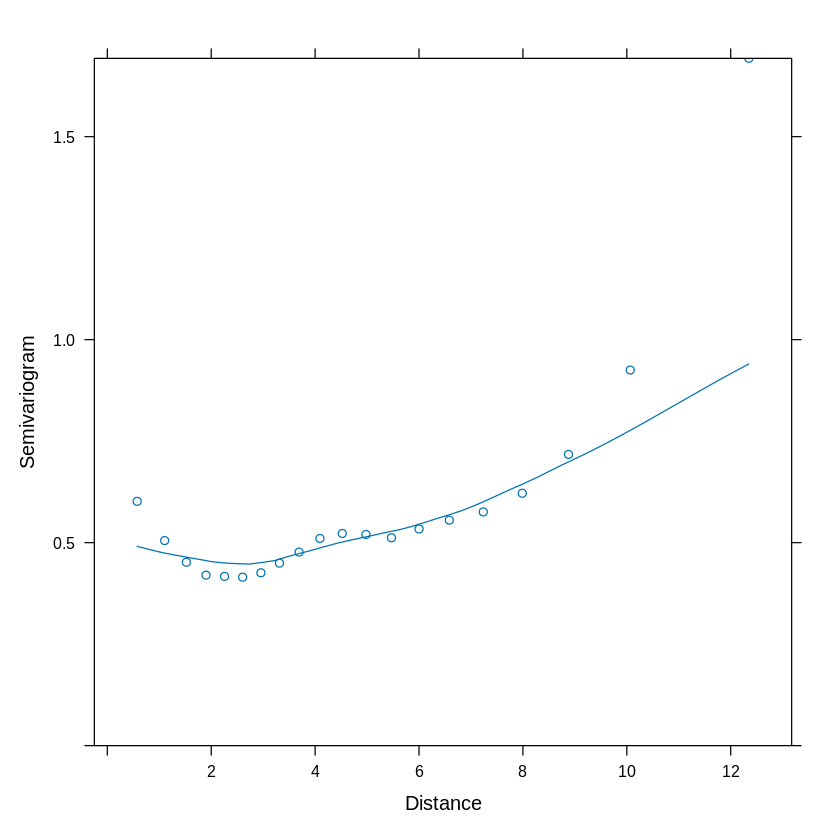

In [8]:
semivario_tempPref <- Variogram(fit_tempPref, form = ~lon + lat, resType = "normalized")
p_semivario_tempPref <- plot(semivario_tempPref, smooth = TRUE)
p_semivario_tempPref

In [9]:
fit_tempPref_linear.autocor <- lme(formula, data = data_selected_tempPref, random = ~1|dataset_name.tempPref,
                                   correlation = corLin(form = ~lon + lat, nugget = T))

In [10]:
summary(fit_tempPref_linear.autocor)
fit_table <- model_parameters(fit_tempPref_linear.autocor)
write.csv(fit_table, '../output/fit_table_tempPref.csv', row.names = F)

Linear mixed-effects model fit by REML
  Data: data_selected_tempPref 
        AIC       BIC   logLik
  -4991.563 -4925.939 2504.781

Random effects:
 Formula: ~1 | dataset_name.tempPref
        (Intercept)  Residual
StdDev:  0.05250813 0.1909967

Correlation Structure: Linear spatial correlation
 Formula: ~lon + lat | dataset_name.tempPref 
 Parameter estimate(s):
       range       nugget 
9.724955e-02 4.064858e-07 
Fixed effects:  list(formula) 
                                                  Value  Std.Error    DF    t-value p-value
(Intercept)                                  0.01097645 0.00799718 10769  1.3725392  0.1699
fishing_effort                              -0.00005011 0.00254662 10769 -0.0196761  0.9843
sst_estimate.tempPref                        0.12585795 0.09910521 10769  1.2699428  0.2041
fishing_effort:sst_estimate.tempPref         0.09709782 0.03941322 10769  2.4635850  0.0138
sst_estimate.tempPref:sst_baseline.tempPref -0.01455760 0.00694213 10769 -2.0969946  0.

In [11]:
p_model_diagnosis_tempPref <- plot(fit_tempPref_linear.autocor)

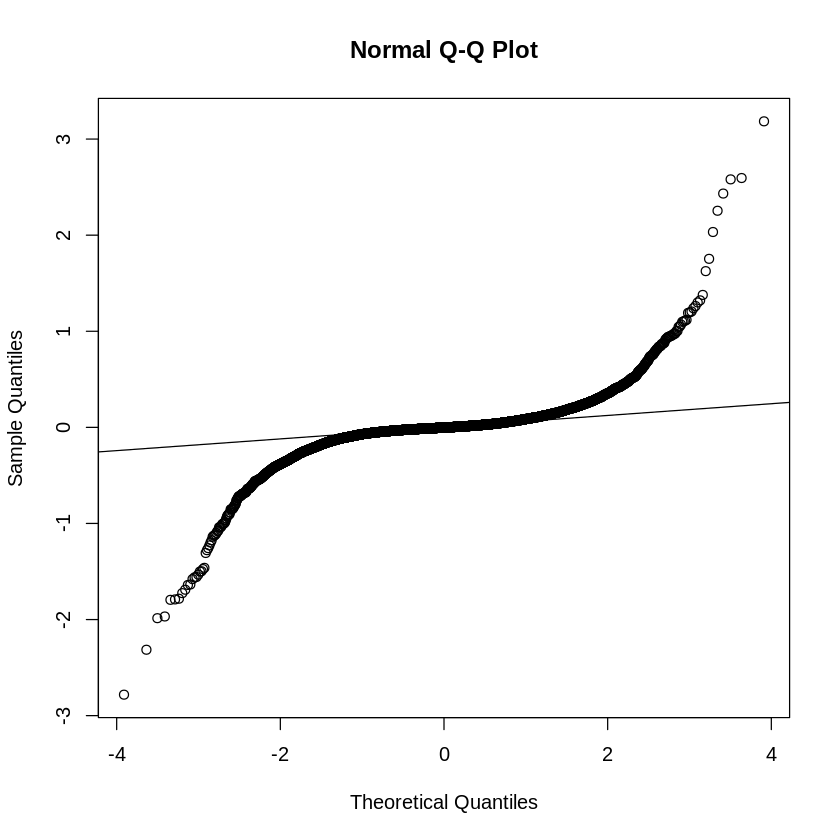

In [62]:
qqnorm(residuals(fit_tempPref_linear.autocor))
qqline(residuals(fit_tempPref_linear.autocor))

In [278]:
# library(parallel)
# clust <- makeCluster(10)
# clusterEvalQ(clust, library(nlme))
# clusterExport(clust, 'data_selected_tempPref')

# options(na.action = "na.fail")
# dd_tempPref <- MuMIn::dredge(fit_tempPref)
# write_csv(as.data.frame(dd_tempPref), '../output/dd_tempPref.csv')
# options(na.action = "na.omit")

# fm_d2_tempPref <- MuMIn::get.models(dd_tempPref, delta < 2)
# fm_avg2_tempPref <- MuMIn::model.avg(
#   fm_d2_tempPref,
#   beta = "partial.sd")

# fm_avg2_tempPref %>%
#   model_parameters() %>% write.csv('../output/fit_table_tempPref_average.csv')

# stopCluster(clust)

Warning message in MuMIn::dredge(fit_tempPref):
“comparing models fitted by REML”
Fixed term is "(Intercept)"



In [210]:
line_num <- 70
with(data_selected_tempPref,
     {eff_tempPref1 <<- effects::Effect(c('sst_estimate.tempPref', 'fishing_effort'),
                                        fit_tempPref, xlevels = line_num)})

Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor fishing_effort is a one-column matrix that was converted to a vector”


In [211]:
with(data_selected_tempPref,
     {eff_tempPref2 <<- effects::Effect(c('sst_estimate.tempPref', 'sst_baseline.tempPref'),
                                        fit_tempPref, xlevels = line_num)})

Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor fishing_effort is a one-column matrix that was converted to a vector”


## maxLengthTL model

In [17]:
data_selected_maxLengthTL <- dplyr::select(total_fit, grid, fishing_effort, ends_with('estimate.maxLengthTL'),
                      ends_with('dataset_name.maxLengthTL'), 'sst_baseline.maxLengthTL') %>%
    left_join(grid_point_xy, by = c('grid' = 'seqnum')) %>% 
    # filter(get(paste0('p.value.', traits)) < 0.05) %>%
    mutate(fishing_effort = scale(fishing_effort), grid = as.factor(grid)) %>% 
    distinct() %>% na.omit()
formula <- as.formula('estimate.maxLengthTL ~ fishing_effort * sst_estimate.maxLengthTL * sst_baseline.maxLengthTL')
fit_maxLengthTL <- lme(formula, data = data_selected_maxLengthTL, random = ~1|dataset_name.maxLengthTL)
summary(fit_maxLengthTL)

Linear mixed-effects model fit by REML
  Data: data_selected_maxLengthTL 
       AIC      BIC    logLik
  53435.27 53508.18 -26707.63

Random effects:
 Formula: ~1 | dataset_name.maxLengthTL
        (Intercept) Residual
StdDev:   0.6560759 2.822409

Fixed effects:  list(formula) 
                                                                     Value Std.Error    DF   t-value p-value
(Intercept)                                                      -0.057695 0.1971144 10766 -0.292699  0.7698
fishing_effort                                                    0.287721 0.1257035 10766  2.288884  0.0221
sst_estimate.maxLengthTL                                          5.074357 1.5199430 10766  3.338518  0.0008
sst_baseline.maxLengthTL                                         -0.007904 0.0094030 10766 -0.840553  0.4006
fishing_effort:sst_estimate.maxLengthTL                           0.249396 1.7822868 10766  0.139930  0.8887
fishing_effort:sst_baseline.maxLengthTL                          

In [84]:
semivario_maxLengthTL <- Variogram(fit_maxLengthTL, form = ~lon + lat, resType = "normalized")
p_semivario_maxLengthTL <- plot(semivario_maxLengthTL, smooth = TRUE)
options(repr.plot.width = 11, repr.plot.height = 7)
p_semivario_maxLengthTL

In [67]:
fit_maxLengthTL_linear.autocor <- lme(formula, data = data_selected_maxLengthTL, random = ~1|dataset_name.maxLengthTL,
                                      correlation = corLin(form = ~lon + lat, nugget=T), method = 'ML')

In [68]:
summary(fit_maxLengthTL_linear.autocor)
fit_table <- model_parameters(fit_maxLengthTL_linear.autocor)
write.csv(fit_table, '../output/fit_table_maxLengthTL.csv', row.names = F)

Linear mixed-effects model fit by maximum likelihood
  Data: data_selected_maxLengthTL 
       AIC      BIC    logLik
  52896.12 52983.63 -26436.06

Random effects:
 Formula: ~1 | dataset_name.maxLengthTL
        (Intercept) Residual
StdDev:   0.3383608 2.898223

Correlation Structure: Linear spatial correlation
 Formula: ~lon + lat | dataset_name.maxLengthTL 
 Parameter estimate(s):
    range    nugget 
0.8248406 0.7842717 
Fixed effects:  list(formula) 
                                                                      Value Std.Error    DF    t-value p-value
(Intercept)                                                      -0.1224123 0.2109780 10770 -0.5802139  0.5618
fishing_effort                                                    0.1516327 0.1427142 10770  1.0624919  0.2880
sst_estimate.maxLengthTL                                          1.4077002 1.5941219 10770  0.8830568  0.3772
sst_baseline.maxLengthTL                                         -0.0038843 0.0118133 10770 -0.3

In [ ]:
library(parallel)
clust <- makeCluster(10)
clusterEvalQ(clust, library(nlme))
clusterExport(clust, 'data_selected_maxLengthTL')

# options(na.action = "na.fail")
dd_maxLengthTL <- MuMIn::dredge(fit_maxLengthTL_linear.autocor, cluster = clust)
write_csv(as.data.frame(dd_maxLengthTL), '../output/dd_maxLengthTL.csv')
# options(na.action = "na.omit")
stopCluster(clust)

In [75]:
fm_d2_maxLengthTL <- MuMIn::get.models(dd_maxLengthTL, delta < 2)
fm_avg_maxLengthTL <- MuMIn::model.avg(
  fm_d2_maxLengthTL,
  beta = "partial.sd")

fm_avg_maxLengthTL %>%
  model_parameters() %>% write.csv('../output/fit_table_maxLengthTL_average.csv')

In [ ]:
# with(data_selected_maxLengthTL, {eff_maxLengthTL <<- effects::Effect(c('sst_estimate.maxLengthTL', 'fishing_effort'),
#                                                          fit_maxLengthTL_linear.autocor, xlevels = line_num)})

## Troph model

In [18]:
data_selected_Troph <- dplyr::select(total_fit, grid, fishing_effort, ends_with('estimate.Troph'),
                      ends_with('dataset_name.Troph'), 'sst_baseline.Troph') %>%
    left_join(grid_point_xy, by = c('grid' = 'seqnum')) %>% 
    # filter(get(paste0('p.value.', traits)) < 0.05) %>%
    mutate(fishing_effort = scale(fishing_effort), grid = as.factor(grid)) %>% 
    distinct() %>% na.omit()
formula <- as.formula('estimate.Troph ~ fishing_effort * sst_estimate.Troph * sst_baseline.Troph')
fit_Troph <- lme(formula, data = data_selected_Troph, random = ~1|dataset_name.Troph)
summary(fit_Troph)

Linear mixed-effects model fit by REML
  Data: data_selected_Troph 
       AIC       BIC   logLik
  -48118.1 -48045.19 24069.05

Random effects:
 Formula: ~1 | dataset_name.Troph
        (Intercept)   Residual
StdDev: 0.006447029 0.02610764

Fixed effects:  list(formula) 
                                                           Value   Std.Error    DF   t-value p-value
(Intercept)                                          -0.00671200 0.001868987 10766 -3.591251  0.0003
fishing_effort                                        0.00348008 0.001166224 10766  2.984053  0.0029
sst_estimate.Troph                                    0.16558988 0.014095933 10766 11.747352  0.0000
sst_baseline.Troph                                    0.00024367 0.000088048 10766  2.767411  0.0057
fishing_effort:sst_estimate.Troph                     0.03381834 0.016520873 10766  2.047007  0.0407
fishing_effort:sst_baseline.Troph                    -0.00024090 0.000087476 10766 -2.753914  0.0059
sst_estimate.Troph:s

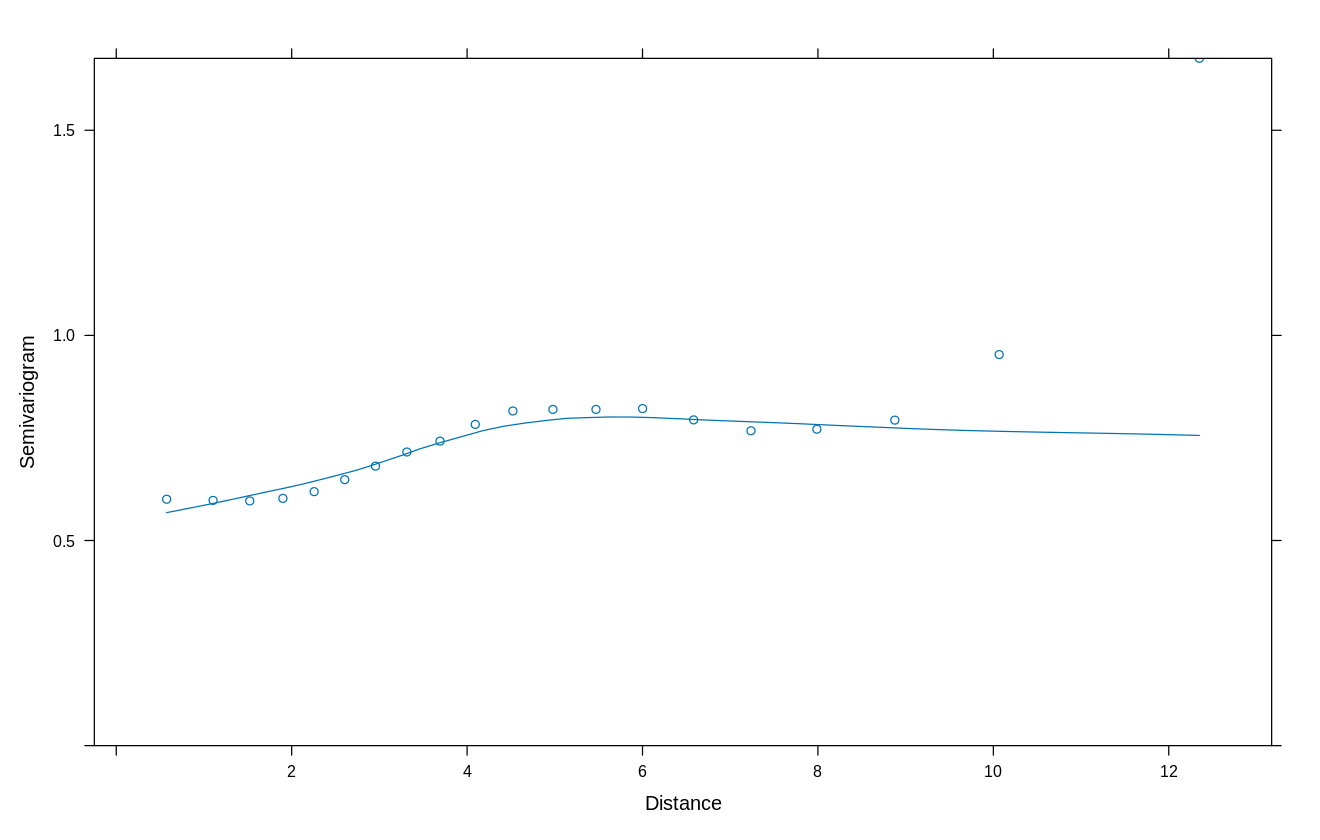

In [138]:
semivario_Troph <- Variogram(fit_Troph, form = ~lon + lat, resType = "normalized")
p_semivario_Troph <- plot(semivario_Troph, smooth = TRUE)
p_semivario_Troph

In [78]:
fit_Troph_linear.autocor <- lme(formula, data = data_selected_Troph, random = ~1|dataset_name.Troph,
                                correlation = corLin(form = ~lon + lat, nugget = T), method = 'ML')

In [ ]:
summary(fit_Troph_linear.autocor)
fit_table <- model_parameters(fit_Troph_linear.autocor)
write.csv(fit_table, '../output/fit_table_Troph.csv', row.names = F)

In [ ]:
library(parallel)
clust <- makeCluster(10)
clusterExport(clust, 'data_selected_Troph')

options(na.action = "na.fail")
dd_Troph <- MuMIn::pdredge(fit_Troph_linear.autocor, cluster = clust)
write_csv(as.data.frame(dd_Troph), '../output/dd_Troph.csv')
options(na.action = "na.omit")

fm_d2_Troph <- MuMIn::get.models(dd_Troph, delta < 2)
fm_avg2_Troph <- MuMIn::model.avg(
  fm_d2_Troph,
  beta = "partial.sd")

fm_avg2_Troph %>%
  model_parameters() %>% write.csv('../output/fit_table_Troph_average.csv')

stopCluster(clust)

In [214]:
with(data_selected_Troph,
     {eff_Troph1 <<- effects::Effect(c('sst_estimate.Troph', 'fishing_effort'),
                                     fit_Troph, xlevels = line_num)})

Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor fishing_effort is a one-column matrix that was converted to a vector”


In [215]:
with(data_selected_Troph,
     {eff_Troph2 <<- effects::Effect(c('sst_estimate.Troph', 'sst_baseline.Troph'),
                                     fit_Troph, xlevels = line_num)})

Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor fishing_effort is a one-column matrix that was converted to a vector”


## plot

### interaction plot

In [218]:
options(repr.plot.width = 16, repr.plot.height = 9)
a <- plot(eff_tempPref1, 
     colors = paletteer::paletteer_c("grDevices::Zissou 1", line_num),
     lines = list(multiline = T, y.intersp = 0, lwd = 7),
     key.args = list(space = "right", columns = 1, cex = 0.2, cex.title = 1, title = 'fishing effort'),
     main = NULL, xlab = 'SST trend (\u00B0C/yr)', ylab = 'tempPref trend (\u00B0C/yr)')
b <- plot(eff_tempPref2, 
     colors = paletteer::paletteer_c("grDevices::Zissou 1", line_num),
     lines = list(multiline = T, y.intersp = 0, lwd = 7),
     key.args = list(space = "right", columns = 1, cex = 0.2, cex.title = 1, title = 'SST baseline (\u00B0C)'),
     main = NULL, xlab = 'SST trend (\u00B0C/yr)', ylab = 'tempPref trend (\u00B0C/yr)')
# c <- plot(eff_maxLengthTL, 
#      colors = paletteer::paletteer_c("grDevices::Zissou 1", line_num),
#      lines = list(multiline = T, y.intersp = 0, lwd = 7),
#      key.args = list(space = "right", columns = 1, cex = 0.2, cex.title = 1, title = 'fishing effort'),
#      main = NULL, xlab='SST trend (\u00B0C/yr)', ylab = 'maxLengthTL trend (cm/yr)')
d <- plot(eff_Troph1, 
     colors = paletteer::paletteer_c("grDevices::Zissou 1", line_num),
     lines = list(multiline = T, y.intersp = 0, lwd = 7),
     key.args = list(space = "right", columns = 1, cex = 0.2, cex.title = 1, title = 'fishing effort'),
     main = NULL, xlab = 'SST trend (\u00B0C/yr)', ylab = 'Trophic level trend per year')
e <- plot(eff_Troph2, 
     colors = paletteer::paletteer_c("grDevices::Zissou 1", line_num),
     lines = list(multiline = T, y.intersp = 0, lwd = 7),
     key.args = list(space = "right", columns = 1, cex = 0.2, cex.title = 1, title = 'SST baseline (\u00B0C)'),
     main = NULL, xlab = 'SST trend (\u00B0C/yr)', ylab = 'Trophic level trend per year')

In [220]:
pdf('../output/interaction_plot2.pdf', height = 13, width = 21)
cowplot::plot_grid(a, b, d, e, labels = 'AUTO', label_size = 18, ncol = 2, rel_widths = c(0.95, 1))
dev.off()

png 
  2

### model plot

In [142]:
load('../output/tempPref_fit_spatial_autocorr.Rdata')
load('../output/maxLengthT_fit_spatial_autocorr_increase_iters.Rdata')
load('../output/Troph_fit_spatial_autocorr.Rdata')

In [14]:
pdf('../output/spatial_autocorrelation.pdf', height = 7, width = 22)
cowplot::plot_grid(p_semivario_tempPref, p_semivario_maxLengthTL, p_semivario_Troph, labels = 'AUTO', ncol = 3, rel_widths = c(0.95, 1), label_size = 24)
dev.off()

png 
  2

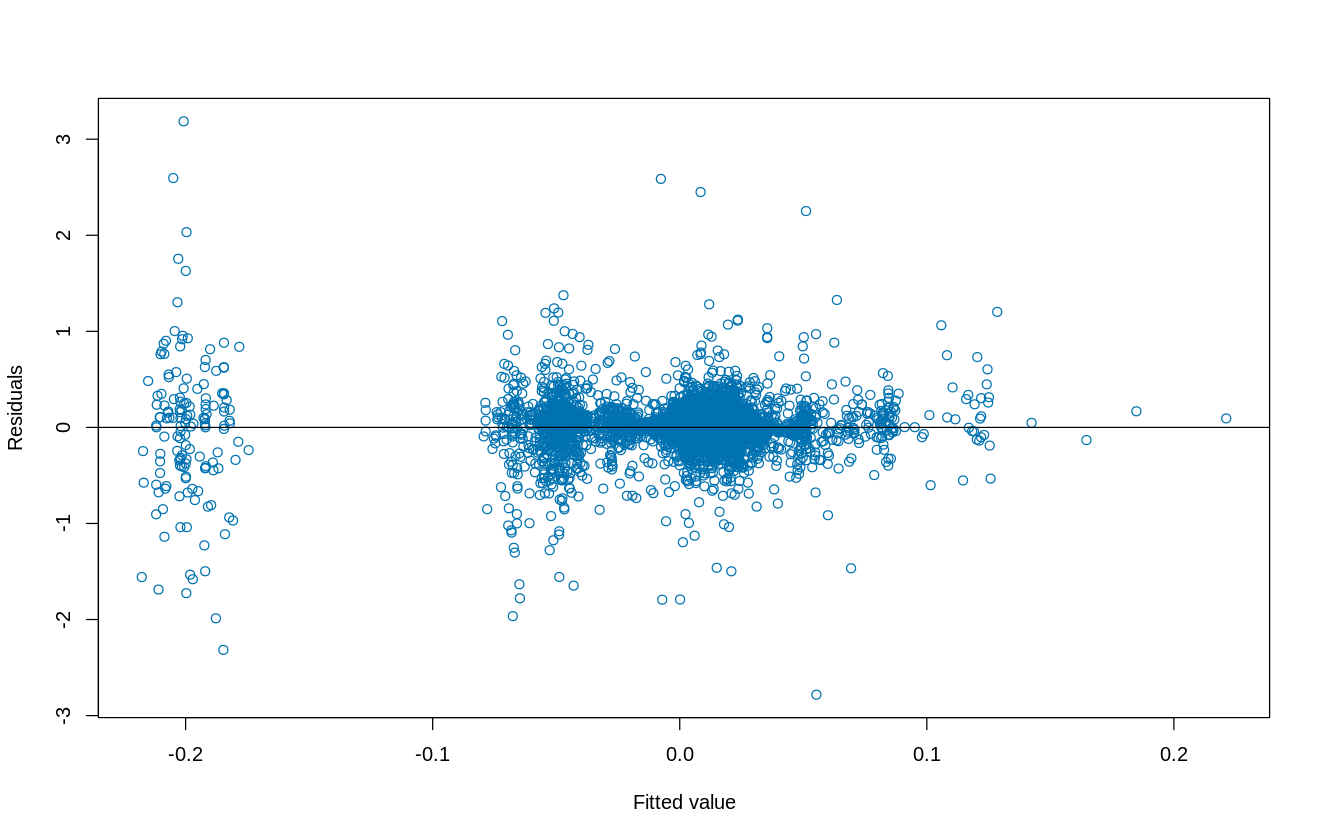

In [143]:
predicted_tempPref <- predict(fm_avg2_tempPref)
data_selected_tempPref_predicted <- cbind(data_selected_tempPref, predicted_tempPref) %>% 
    mutate(resid = estimate.tempPref - predicted_tempPref)
pdf(NULL)
dev.control(displaylist="enable")
plot(data_selected_tempPref_predicted$predicted_tempPref, data_selected_tempPref_predicted$resid, xlab = "Fitted value", ylab = "Residuals", col = '#0072b1')
abline(h = 0)
p_model_diagnosis_tempPref <- recordPlot()
invisible(dev.off())

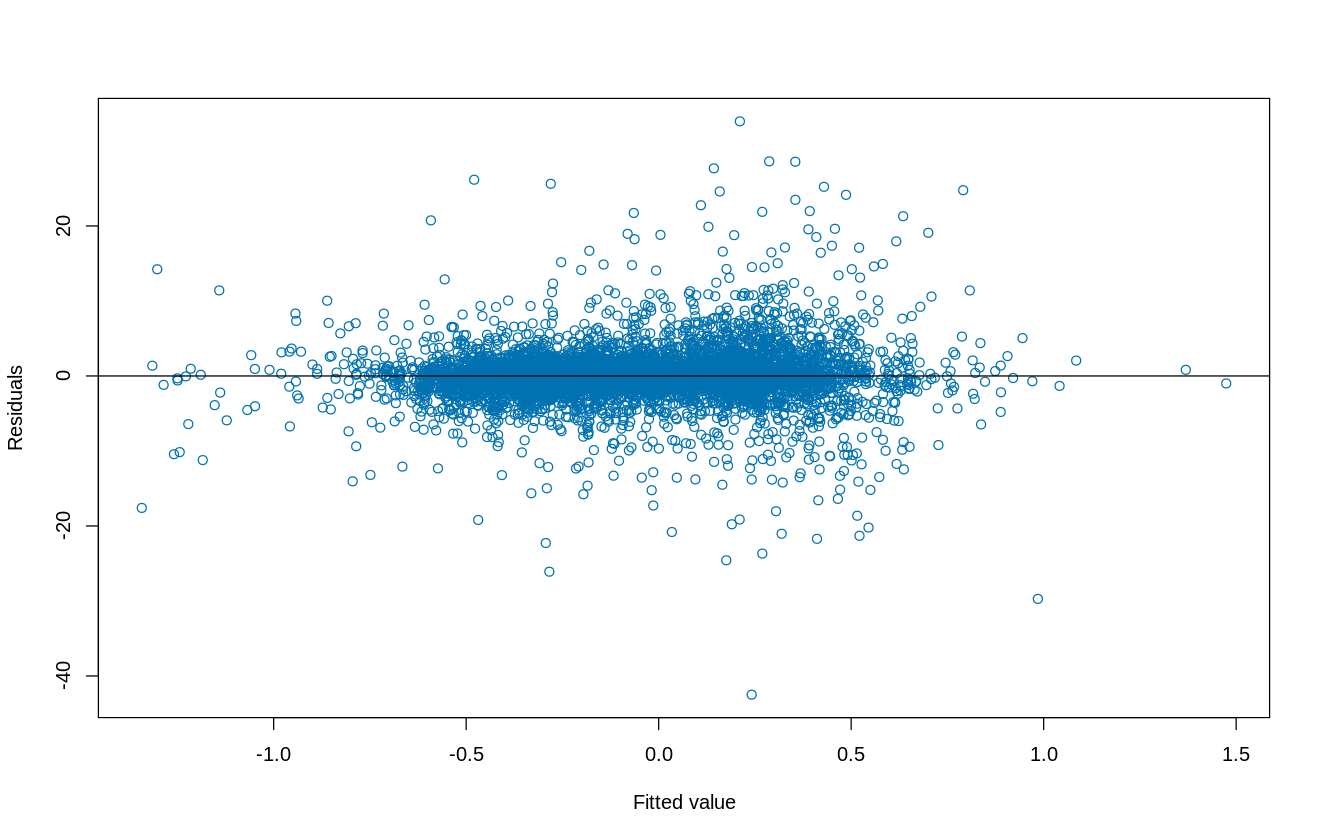

In [144]:
predicted_maxLengthTL <- predict(fm_avg_maxLengthTL)
data_selected_maxLengthTL_predicted <- cbind(data_selected_maxLengthTL, predicted_maxLengthTL) %>% 
    mutate(resid = estimate.maxLengthTL - predicted_maxLengthTL)
pdf(NULL)
dev.control(displaylist="enable")
plot(data_selected_maxLengthTL_predicted$predicted_maxLengthTL, data_selected_maxLengthTL_predicted$resid, xlab = "Fitted value", ylab = "Residuals", col = '#0072b1')
abline(h = 0)
p_model_diagnosis_maxLengthTL <- recordPlot()
invisible(dev.off())

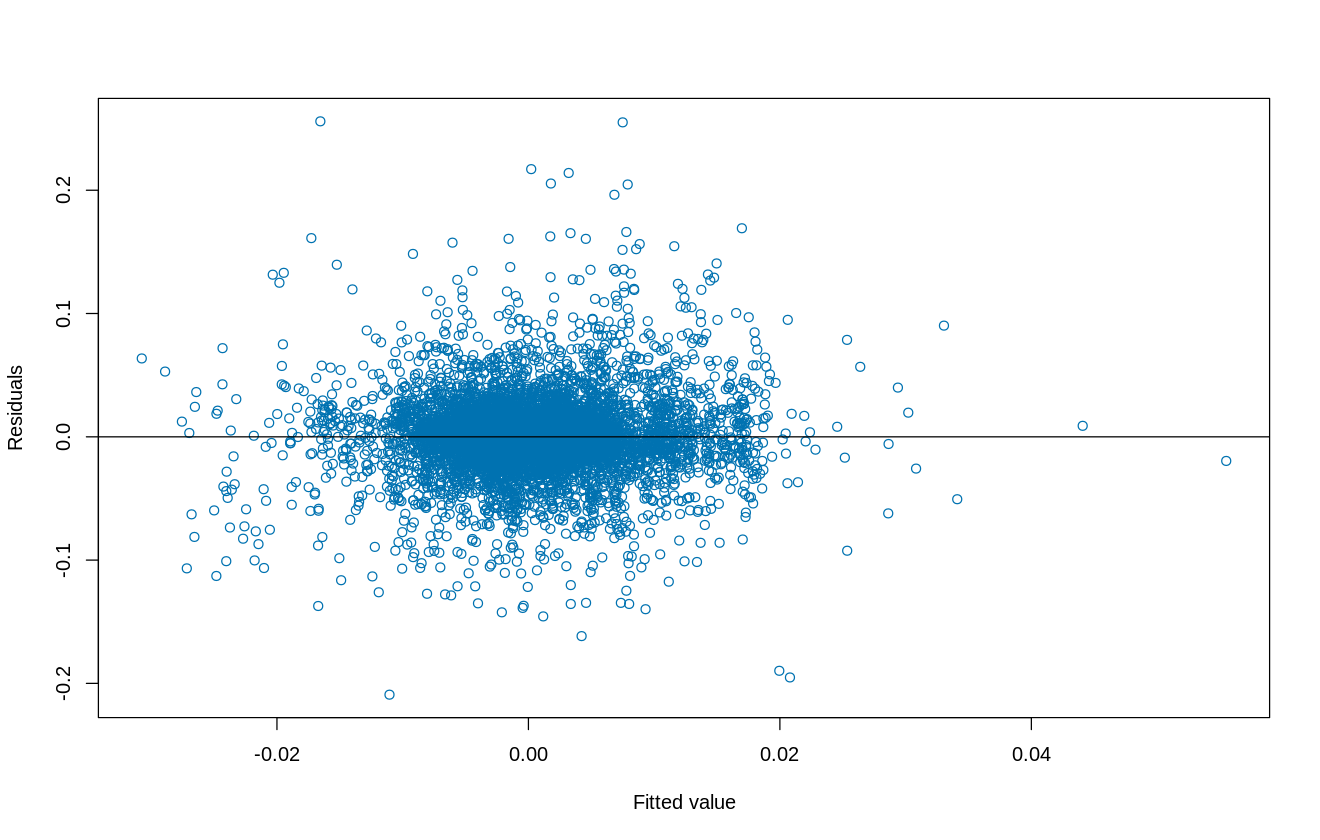

In [145]:
predicted_Troph <- predict(fm_avg2_Troph)
data_selected_Troph_predicted <- cbind(data_selected_Troph, predicted_Troph) %>% 
    mutate(resid = estimate.Troph - predicted_Troph)
pdf(NULL)
dev.control(displaylist="enable")
plot(data_selected_Troph_predicted$predicted_Troph, data_selected_Troph_predicted$resid, xlab = "Fitted value", ylab = "Residuals", col = '#0072b1')
abline(h = 0)
p_model_diagnosis_Troph <- recordPlot()
invisible(dev.off())

In [158]:
DHARMa::simulateResiduals(fm_avg2_Troph, plot = TRUE)

Warning message in checkModel(fittedModel):
“DHARMa: fittedModel not in class of supported models. Absolutely no guarantee that this will work!”


ERROR: Error in get(as.character(FUN), mode = "function", envir = envir): object 'model.avg' of mode 'function' was not found


In [146]:
library(gridGraphics)
pdf('../output/model_diagnosis.pdf', height = 7, width = 22)
cowplot::plot_grid(p_model_diagnosis_tempPref, p_model_diagnosis_maxLengthTL, p_model_diagnosis_Troph, labels = 'AUTO', ncol = 3, rel_widths = c(0.95, 1), label_size = 24)
dev.off()

png 
  2

In [147]:
library(data.table)
lme_average_coff_table_tempPref <- as.data.frame(summary(fm_avg2_tempPref)$coefmat.subset)
setDT(lme_average_coff_table_tempPref, keep.rownames = "coefficient") #put rownames into column
names(lme_average_coff_table_tempPref) <- gsub(" ", "", names(lme_average_coff_table_tempPref)) # remove spaces from column headers
lme_average_coff_table_tempPref <- filter(lme_average_coff_table_tempPref, coefficient != '(Intercept)') %>%
    mutate(sig = case_when(get('Pr(>|z|)') < 0.05 & Estimate > 0 ~ 'pos_sig',
                           get('Pr(>|z|)') < 0.05 & Estimate < 0 ~ 'neg_sig',
                           get('Pr(>|z|)') > 0.05  ~ 'insig',
                          ),
           coefficient = gsub('_', ' ', coefficient),
           coefficient = gsub('.tempPref', '', coefficient),
           coefficient = gsub(':', ' × ', coefficient),
           coefficient = gsub('sst', 'SST', coefficient),
           coefficient = gsub('estimate', 'trend', coefficient),
           coefficient = factor(coefficient, levels = c('fishing effort × SST baseline', 'fishing effort × SST trend', 'SST baseline × SST trend','SST trend', 'SST baseline', 'fishing effort'))
          )
head(lme_average_coff_table_tempPref)

coefficient,Estimate,Std.Error,AdjustedSE,zvalue,Pr(>|z|),sig
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
fishing effort,-0.001379440,0.002163102,0.002163320,0.6376495,0.5237018,insig
SST baseline,-0.005869230,0.003400243,0.003400595,1.7259422,0.0843578,insig
SST trend,-0.001564038,0.003661662,0.003661802,0.4271225,0.6692901,insig
fishing effort × SST baseline,0.002084886,0.002195844,0.002196091,0.9493625,0.3424363,insig
fishing effort × SST trend,0.005288715,0.001905811,0.001906022,2.7747392,0.0055246,pos_sig
SST baseline × SST trend,-0.004021994,0.002216055,0.002216304,1.8147301,0.0695654,insig


In [148]:
p_model_avg_tempPref <- ggplot(data = lme_average_coff_table_tempPref, aes(x=coefficient, y=Estimate))+ #again, excluding intercept because estimates so much larger
      geom_hline(yintercept=0, color = "grey",linetype="dashed", lwd=1)+ #add dashed line at zero
      geom_errorbar(aes(ymin=Estimate-AdjustedSE, ymax=Estimate+AdjustedSE, color = sig), #adj SE
                  width=0.15, lwd=1.5) +
      xlab('term')+
      coord_flip()+ # flipping x and y axes
      geom_point(size=6, aes(color = sig))+
      scale_color_manual(values = c('grey',"#f8766d","#00bfc4"))+
      ylab("Coefficient")+
      theme_bw()+
      theme(panel.grid = element_blank(), legend.position = 'none')

In [149]:
library(data.table)
lme_average_coff_table_maxLengthTL <- as.data.frame(summary(fm_avg_maxLengthTL)$coefmat.subset)
setDT(lme_average_coff_table_maxLengthTL, keep.rownames = "coefficient") #put rownames into column
names(lme_average_coff_table_maxLengthTL) <- gsub(" ", "", names(lme_average_coff_table_maxLengthTL)) # remove spaces from column headers
lme_average_coff_table_maxLengthTL <- filter(lme_average_coff_table_maxLengthTL, coefficient != '(Intercept)') %>%
    mutate(sig = case_when(get('Pr(>|z|)') < 0.05 & Estimate > 0 ~ 'pos_sig',
                           get('Pr(>|z|)') < 0.05 & Estimate < 0 ~ 'neg_sig',
                           get('Pr(>|z|)') > 0.05  ~ 'insig',
                          ),
           coefficient = gsub('_', ' ', coefficient),
           coefficient = gsub('.maxLengthTL', '', coefficient),
           coefficient = gsub(':', ' × ', coefficient),
           coefficient = gsub('sst', 'SST', coefficient),
           coefficient = gsub('estimate', 'trend', coefficient),
           coefficient = factor(coefficient, levels = c('fishing effort × SST baseline × SST trend','fishing effort × SST baseline', 'fishing effort × SST trend', 'SST baseline × SST trend','SST trend', 'SST baseline', 'fishing effort'))
          )
lme_average_coff_table_maxLengthTL

coefficient,Estimate,Std.Error,AdjustedSE,zvalue,Pr(>|z|),sig
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
fishing effort,0.017747781,0.03964096,0.03964474,0.44767050,0.6543910,insig
SST baseline,0.001676974,0.05899600,0.05900261,0.02842203,0.9773256,insig
SST trend,0.148539454,0.07199886,0.07200054,2.06303254,0.0391095,pos_sig
fishing effort × SST trend,0.051912214,0.02966012,0.02966346,1.75003935,0.0801115,insig
SST baseline × SST trend,0.034022145,0.03396738,0.03397120,1.00149978,0.3165852,insig


In [150]:
p_model_avg_maxLengthTL <- ggplot(data = lme_average_coff_table_maxLengthTL, aes(x=coefficient, y=Estimate))+ #again, excluding intercept because estimates so much larger
      geom_hline(yintercept=0, color = "grey",linetype="dashed", lwd=1)+ #add dashed line at zero
      geom_errorbar(aes(ymin=Estimate-AdjustedSE, ymax=Estimate+AdjustedSE, color = sig), #adj SE
                  width=0.15, lwd=1.5) +
      xlab('term')+
      coord_flip()+ # flipping x and y axes
      geom_point(size=6, aes(color = sig))+
      scale_color_manual(values = c('grey',"#f8766d","#00bfc4"))+
      ylab("Coefficient")+
      theme_bw()+
      theme(panel.grid = element_blank(), legend.position = 'none')

In [151]:
library(data.table)
lme_average_coff_table_Troph <- as.data.frame(summary(fm_avg2_Troph)$coefmat.subset)
setDT(lme_average_coff_table_Troph, keep.rownames = "coefficient") #put rownames into column
names(lme_average_coff_table_Troph) <- gsub(" ", "", names(lme_average_coff_table_Troph)) # remove spaces from column headers
lme_average_coff_table_Troph <- filter(lme_average_coff_table_Troph, coefficient != '(Intercept)') %>%
    mutate(sig = case_when(get('Pr(>|z|)') < 0.05 & Estimate > 0 ~ 'pos_sig',
                           get('Pr(>|z|)') < 0.05 & Estimate < 0 ~ 'neg_sig',
                           get('Pr(>|z|)') > 0.05  ~ 'insig',
                          ),
           coefficient = gsub('_', ' ', coefficient),
           coefficient = gsub('.Troph', '', coefficient),
           coefficient = gsub(':', ' × ', coefficient),
           coefficient = gsub('sst', 'SST', coefficient),
           coefficient = gsub('estimate', 'trend', coefficient),
           coefficient = factor(coefficient, levels = c('fishing effort × SST baseline × SST trend','fishing effort × SST baseline', 'fishing effort × SST trend', 'SST baseline × SST trend','SST trend', 'SST baseline', 'fishing effort'))
          )
lme_average_coff_table_Troph

coefficient,Estimate,Std.Error,AdjustedSE,zvalue,Pr(>|z|),sig
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
fishing effort,0.0007289986,0.0003587938,0.0003588318,2.0315887,0.0421953,pos_sig
SST baseline,0.0013208290,0.0006337431,0.0006338142,2.0839371,0.0371659,pos_sig
SST trend,0.0027834857,0.0003094430,0.0003094778,8.9941360,0.0000000,pos_sig
fishing effort × SST baseline,-0.0007081522,0.0003650871,0.0003651254,1.9394766,0.0524433,insig
fishing effort × SST trend,0.0007443888,0.0003209279,0.0003209549,2.3192939,0.0203791,pos_sig
SST baseline × SST trend,-0.0015420470,0.0003238982,0.0003239345,4.7603661,0.0000019,neg_sig
fishing effort × SST baseline × SST trend,-0.0002656974,0.0002797223,0.0002797538,0.9497544,0.3422371,insig


In [152]:
p_model_avg_Troph <- ggplot(data = lme_average_coff_table_Troph, aes(x=coefficient, y=Estimate))+ #again, excluding intercept because estimates so much larger
      geom_hline(yintercept=0, color = "grey",linetype="dashed", lwd=1)+ #add dashed line at zero
      geom_errorbar(aes(ymin=Estimate-AdjustedSE, ymax=Estimate+AdjustedSE, color = sig), #adj SE
                  width=0.15, lwd=1.5) +
      xlab('term')+
      coord_flip()+ # flipping x and y axes
      geom_point(size=6, aes(color = sig))+
      scale_color_manual(values = c('grey',"#00bfc4","#f8766d"))+
      ylab("Coefficient")+
      theme_bw()+
      theme(panel.grid = element_blank(), legend.position = 'none')

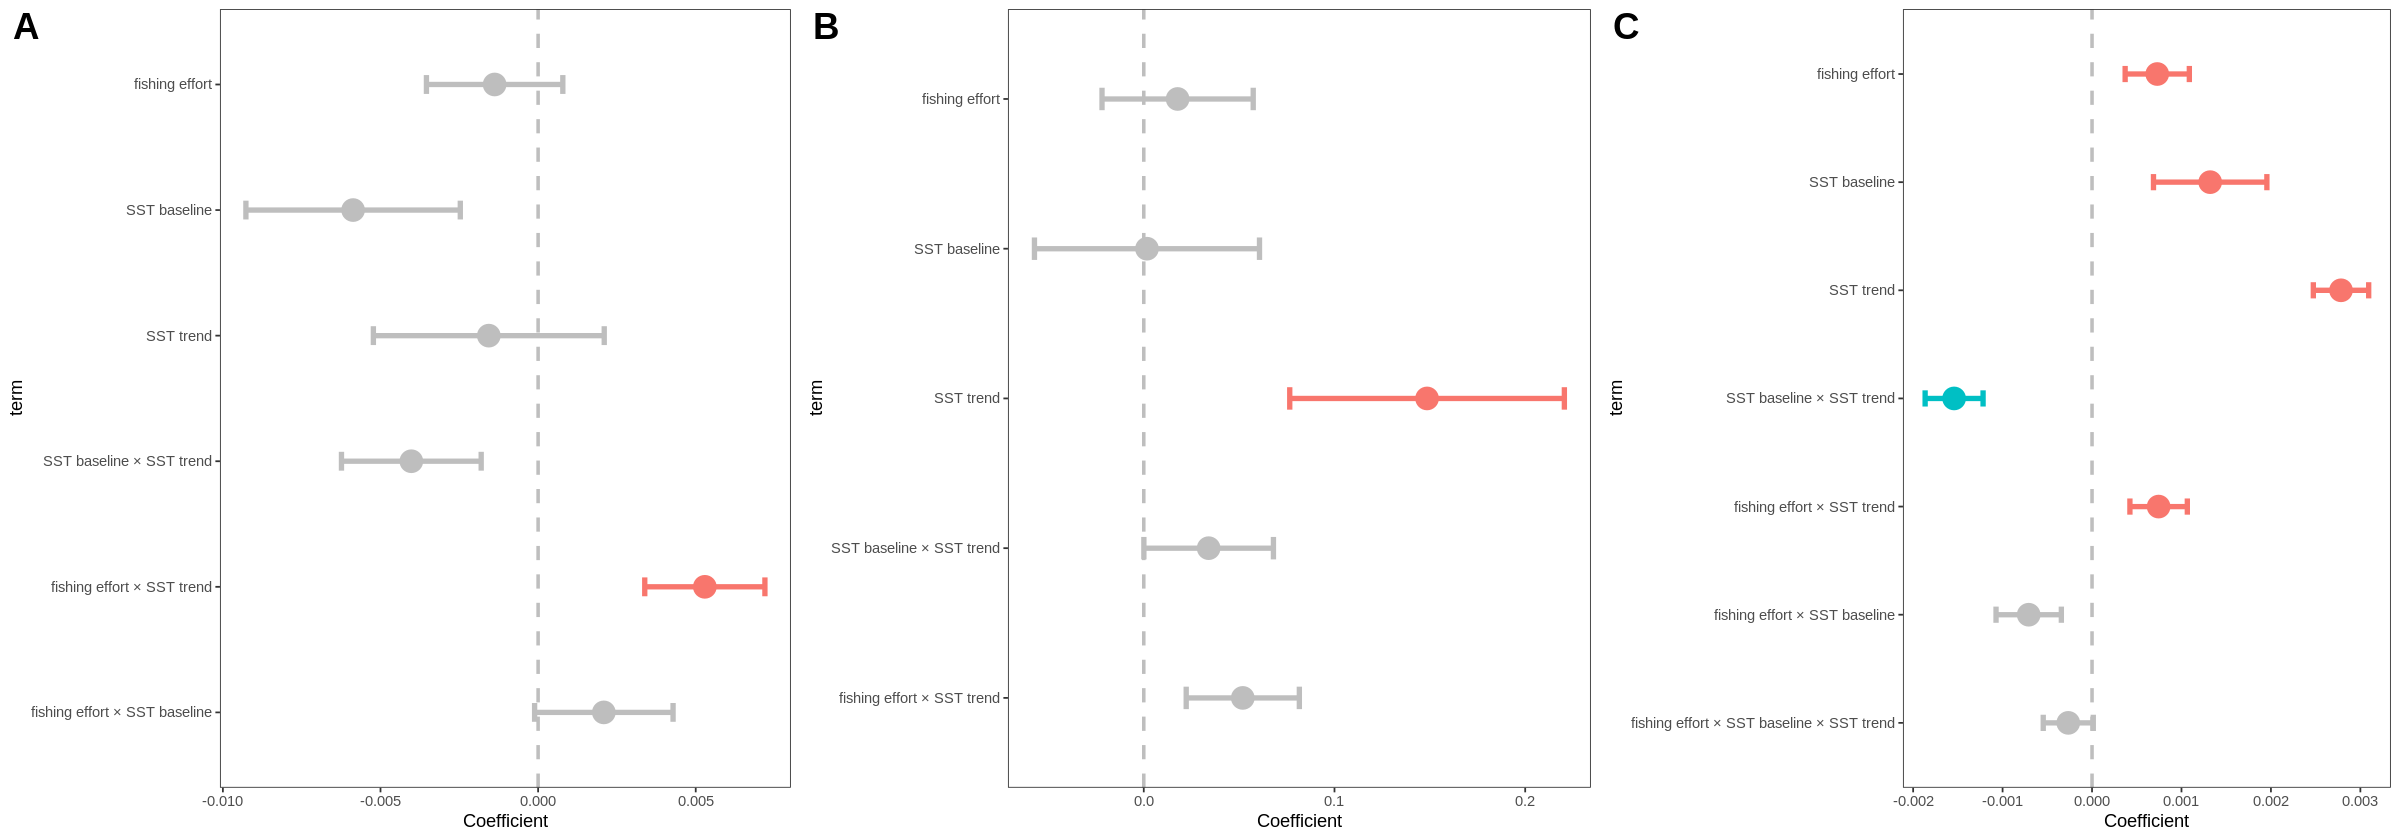

In [154]:
options(repr.plot.width = 20, repr.plot.height = 7)
ggpubr::ggarrange(p_model_avg_tempPref, p_model_avg_maxLengthTL, p_model_avg_Troph, ncol = 3, labels = 'AUTO',
                             font.label = list(size = 22))
ggsave('../output/p_model_avg_combination.pdf', width = 20, height = 7, units = 'cm', scale = 2)
options(repr.plot.width = 11, repr.plot.height = 7)

In [ ]:
# with(data_selected,
#      {eff_tempPref3 <<- effects::Effect(c('sst_estimate.tempPref', 'sst_baseline.tempPref'),
#                                         fit_tempPref, partial.residuals = TRUE, xlevels = 12)})
# plot(eff_tempPref3, 
#     partial.residual=list(pch=".", col="#FF00FF80"),
#      axes = list(y=list(lim={c(-0.2, 0.2)})),
#      main = NULL, xlab = 'SST trends', ylab = 'TempPref',
#     lattice = list(layout = c(4,3)))

# abundance change

## size class

In [221]:
size_class_table <- read_csv('size_class_sst_table.csv') %>% 
    mutate(size_class = factor(size_class, levels = c('(0,8]','(8,11.5]','(11.5,15]','(15,19]','(19,24.4]','(24.4,30]',
                                                         '(30,36.6]','(36.6,45]','(45,56]','(56,75]','(75,Inf]')))
library(dggridR)
library(sf)
dggs <- dgconstruct(res = 12, metric = FALSE)
grid <- dgcellstogrid(dggs, size_class_table$grid)  # shapefile grids for all fit 
grid_point <- st_centroid(grid)
grid_point_xy <- do.call(rbind, st_geometry(grid_point)) %>% 
    as_tibble() %>% cbind(grid_point$seqnum) %>% setNames(c("lon","lat", "seqnum"))

size_class_table <- left_join(size_class_table, grid_point_xy, by = c('grid' = 'seqnum'))
summary(size_class_table)

Rows: 527219 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): dataset_name, size_class
dbl (4): grid, date_year, size_class_weighted_abundance, sst_values

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“st_centroid assumes attributes are constant over geometries”


 dataset_name            grid           date_year        size_class     size_class_weighted_abundance   sst_values         lon          
 Length:527219      Min.   :      1   Min.   :1963   (75,Inf] : 93019   Min.   :0.0000001             Min.   :-1.80   Min.   :-179.911  
 Class :character   1st Qu.: 478951   1st Qu.:1988   (56,75]  : 84692   1st Qu.:0.0086957             1st Qu.:10.25   1st Qu.: -74.461  
 Mode  :character   Median : 547406   Median :1998   (45,56]  : 82447   Median :0.0579330             Median :12.26   Median : -13.739  
                    Mean   :1076874   Mean   :1996   (36.6,45]: 57586   Mean   :0.1819813             Mean   :14.70   Mean   : -26.673  
                    3rd Qu.:1032103   3rd Qu.:2006   (30,36.6]: 50238   3rd Qu.:0.2538872             3rd Qu.:18.87   3rd Qu.:   3.271  
                    Max.   :5269674   Max.   :2021   (24.4,30]: 43055   Max.   :1.0000000             Max.   :29.97   Max.   : 179.940  
                                         

In [166]:
# options(repr.plot.width = 12, repr.plot.height = 7)
# p_abundance_change <- ggplot(size_class_table, aes(x = sst_values, y = size_class_weighted_abundance, color = size_class)) + 
#     # geom_point(alpha = 0.01) +
#     scale_color_manual(values = rev(paletteer::paletteer_c("ggthemes::Orange-Blue-White Diverging", 11))) +
#     stat_smooth(method = lm) + 
#     ylab('abundance') + xlab('sst') + 
#     theme_bw()
# saveRDS(p_abundance_change, '../output/p_abundance_change.rds')

In [222]:
size_class_table <- na.omit(size_class_table) %>% mutate(date_year = as.character(date_year), grid = as.character(grid))
summary(size_class_table)

 dataset_name           grid            date_year             size_class     size_class_weighted_abundance   sst_values         lon          
 Length:526646      Length:526646      Length:526646      (75,Inf] : 92948   Min.   :0.0000001             Min.   :-1.80   Min.   :-179.911  
 Class :character   Class :character   Class :character   (56,75]  : 84629   1st Qu.:0.0086957             1st Qu.:10.25   1st Qu.: -74.463  
 Mode  :character   Mode  :character   Mode  :character   (45,56]  : 82378   Median :0.0579380             Median :12.26   Median : -13.807  
                                                          (36.6,45]: 57509   Mean   :0.1819799             Mean   :14.70   Mean   : -26.829  
                                                          (30,36.6]: 50165   3rd Qu.:0.2539669             3rd Qu.:18.87   3rd Qu.:   3.246  
                                                          (24.4,30]: 42999   Max.   :1.0000000             Max.   :29.97   Max.   : 179.940  
      

In [223]:
size_class_regression <- group_by(size_class_table, size_class) %>%
    group_modify(~ model_parameters(lmer(size_class_weighted_abundance ~ sst_values + (1|dataset_name/grid), data = .x)))

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


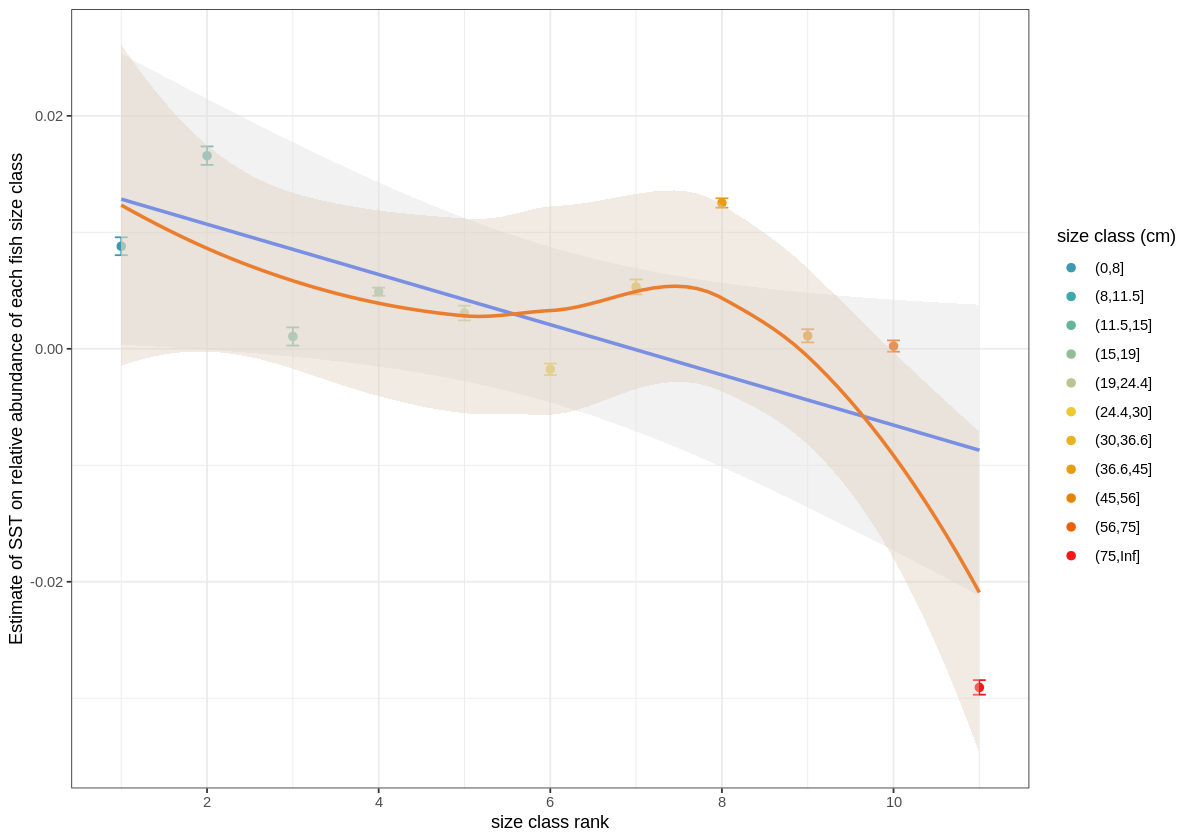

In [243]:
coeff_table <- filter(size_class_regression, Parameter == 'sst_values') %>% 
    mutate(size_class_levels = as.numeric(size_class))
options(repr.plot.width = 10, repr.plot.height = 7)
p_slope <- ggplot(coeff_table, aes(x = size_class_levels, y = Coefficient)) +
    geom_point(aes(color = size_class), size = 2) + 
    geom_errorbar(aes(ymin = Coefficient - SE,
                      ymax = Coefficient + SE,
                      color = size_class),
                  show.legend = FALSE, 
                  width = 0.15) +
    scale_color_manual(values = paletteer::paletteer_c("grDevices::Zissou 1", 11)) +
    scale_x_continuous(breaks = c(0, 2, 4, 6, 8, 10, 12))+
    stat_smooth(method = lm, fill = '#DCDEDD') + 
    geom_smooth(span = 1, color = '#EA7E2E', fill = "#DFCEBA") +
    xlab('size class rank') +
    ylab('Estimate of SST on relative abundance of each fish size class') +
    labs(color = 'size class (cm)') +
    theme(legend.text = element_text(size = 18)) +
    theme_bw()
p_slope
# ggsave('../output/p_slopev2.pdf', height = 6, width = 8.7, units = 'cm', scale = 2.5)

In [225]:
abundance_fit <- lm(Coefficient ~ size_class_levels, data = coeff_table)
summary(abundance_fit)
coeff_table_lm_fit <- model_parameters(abundance_fit)
# write.csv(coeff_table, '../output/coeff_table.csv', row.names = F)
# write.csv(coeff_table_lm_fit, '../output/coeff_table_lm_fit.csv', row.names = F)


Call:
lm(formula = Coefficient ~ size_class_levels, data = coeff_table)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.020363 -0.003936 -0.001157  0.005701  0.014760 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)        0.0150044  0.0063333   2.369   0.0420 *
size_class_levels -0.0021556  0.0009338  -2.308   0.0464 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.009794 on 9 degrees of freedom
Multiple R-squared:  0.3719,	Adjusted R-squared:  0.3021 
F-statistic: 5.329 on 1 and 9 DF,  p-value: 0.04635


In [226]:
abundance_fit_loess <- loess(Coefficient ~ size_class_levels, data = coeff_table, span = 1)
summary(abundance_fit_loess)

Call:
loess(formula = Coefficient ~ size_class_levels, data = coeff_table, 
    span = 1)

Number of Observations: 11 
Equivalent Number of Parameters: 3.49 
Residual Standard Error: 0.007125 
Trace of smoother matrix: 3.8  (exact)

Control settings:
  span     :  1 
  degree   :  2 
  family   :  gaussian
  surface  :  interpolate	  cell = 0.2
  normalize:  TRUE
 parametric:  FALSE
drop.square:  FALSE 

## trophic levels

In [230]:
troph_class_table <- read_csv('troph_class_sst_table.csv') %>% 
    mutate(troph_class = factor(troph_class, levels = c('(0,2.69]','(2.69,3.07]','(3.07,3.24]','(3.24,3.34]','(3.34,3.4]','(3.4,3.49]',
                                                         '(3.49,3.54]','(3.54,3.64]','(3.64,3.81]','(3.81,4]','(4,Inf]')))
summary(troph_class_table)

Rows: 613629 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): dataset_name, troph_class
dbl (4): grid, date_year, troph_class_weighted_abundance, sst_values

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


 dataset_name            grid           date_year         troph_class     troph_class_weighted_abundance   sst_values   
 Length:613629      Min.   :      1   Min.   :1963   (4,Inf]    : 88854   Min.   :0.00000                Min.   :-1.80  
 Class :character   1st Qu.: 484781   1st Qu.:1988   (3.64,3.81]: 79182   1st Qu.:0.00596                1st Qu.:10.15  
 Mode  :character   Median : 547422   Median :1998   (3.81,4]   : 67943   Median :0.04196                Median :11.80  
                    Mean   :1036523   Mean   :1996   (3.07,3.24]: 66653   Mean   :0.15636                Mean   :14.36  
                    3rd Qu.: 655361   3rd Qu.:2006   (3.34,3.4] : 63157   3rd Qu.:0.19952                3rd Qu.:17.72  
                    Max.   :5269674   Max.   :2021   (3.54,3.64]: 62022   Max.   :1.00000                Max.   :29.97  
                                                     (Other)    :185818                                  NA's   :637    

In [231]:
troph_class_regression <- group_by(troph_class_table, troph_class) %>%
    group_modify(~ model_parameters(lmer(troph_class_weighted_abundance ~ sst_values + (1|dataset_name/grid), data = .x)))

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


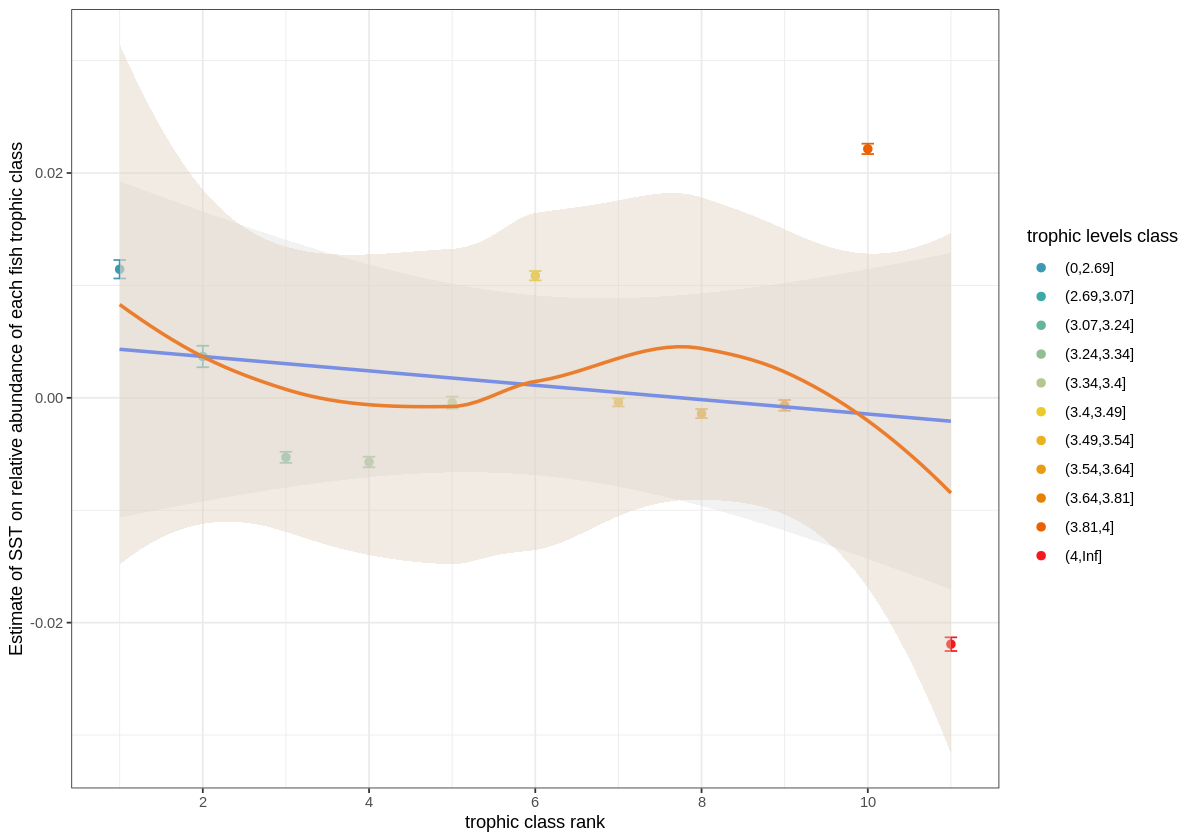

In [244]:
coeff_table_troph <- filter(troph_class_regression, Parameter == 'sst_values') %>% 
    mutate(troph_class_levels = as.numeric(troph_class))
options(repr.plot.width = 10, repr.plot.height = 7)
p_slope_troph <- ggplot(coeff_table_troph, aes(x = troph_class_levels, y = Coefficient)) +
    geom_point(aes(color = troph_class), size = 2) + 
    geom_errorbar(aes(ymin = Coefficient - SE,
                      ymax = Coefficient + SE,
                      color = troph_class),
                  show.legend = FALSE, 
                  width = 0.15) +
    scale_color_manual(values = paletteer::paletteer_c("grDevices::Zissou 1", 11)) +
    scale_x_continuous(breaks = c(0, 2, 4, 6, 8, 10, 12))+
    stat_smooth(method = lm, fill = '#DCDEDD') + 
    geom_smooth(span = 1, color = '#EA7E2E', fill = "#DFCEBA") +
    xlab('trophic class rank') +
    ylab('Estimate of SST on relative abundance of each fish trophic class') +
    labs(color = 'trophic levels class') +
    theme(legend.text = element_text(size = 18)) +
    theme_bw()
p_slope_troph
# ggsave('../output/p_slope_troph.pdf', height = 6, width = 8.7, units = 'cm', scale = 2.5)

In [233]:
abundance_fit_troph <- lm(Coefficient ~ troph_class_levels, data = coeff_table_troph)
summary(abundance_fit_troph)


Call:
lm(formula = Coefficient ~ troph_class_levels, data = coeff_table_troph)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0198351 -0.0051441 -0.0008898  0.0036254  0.0235895 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)         0.0049579  0.0075837   0.654    0.530
troph_class_levels -0.0006399  0.0011182  -0.572    0.581

Residual standard error: 0.01173 on 9 degrees of freedom
Multiple R-squared:  0.03512,	Adjusted R-squared:  -0.07209 
F-statistic: 0.3275 on 1 and 9 DF,  p-value: 0.5811


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


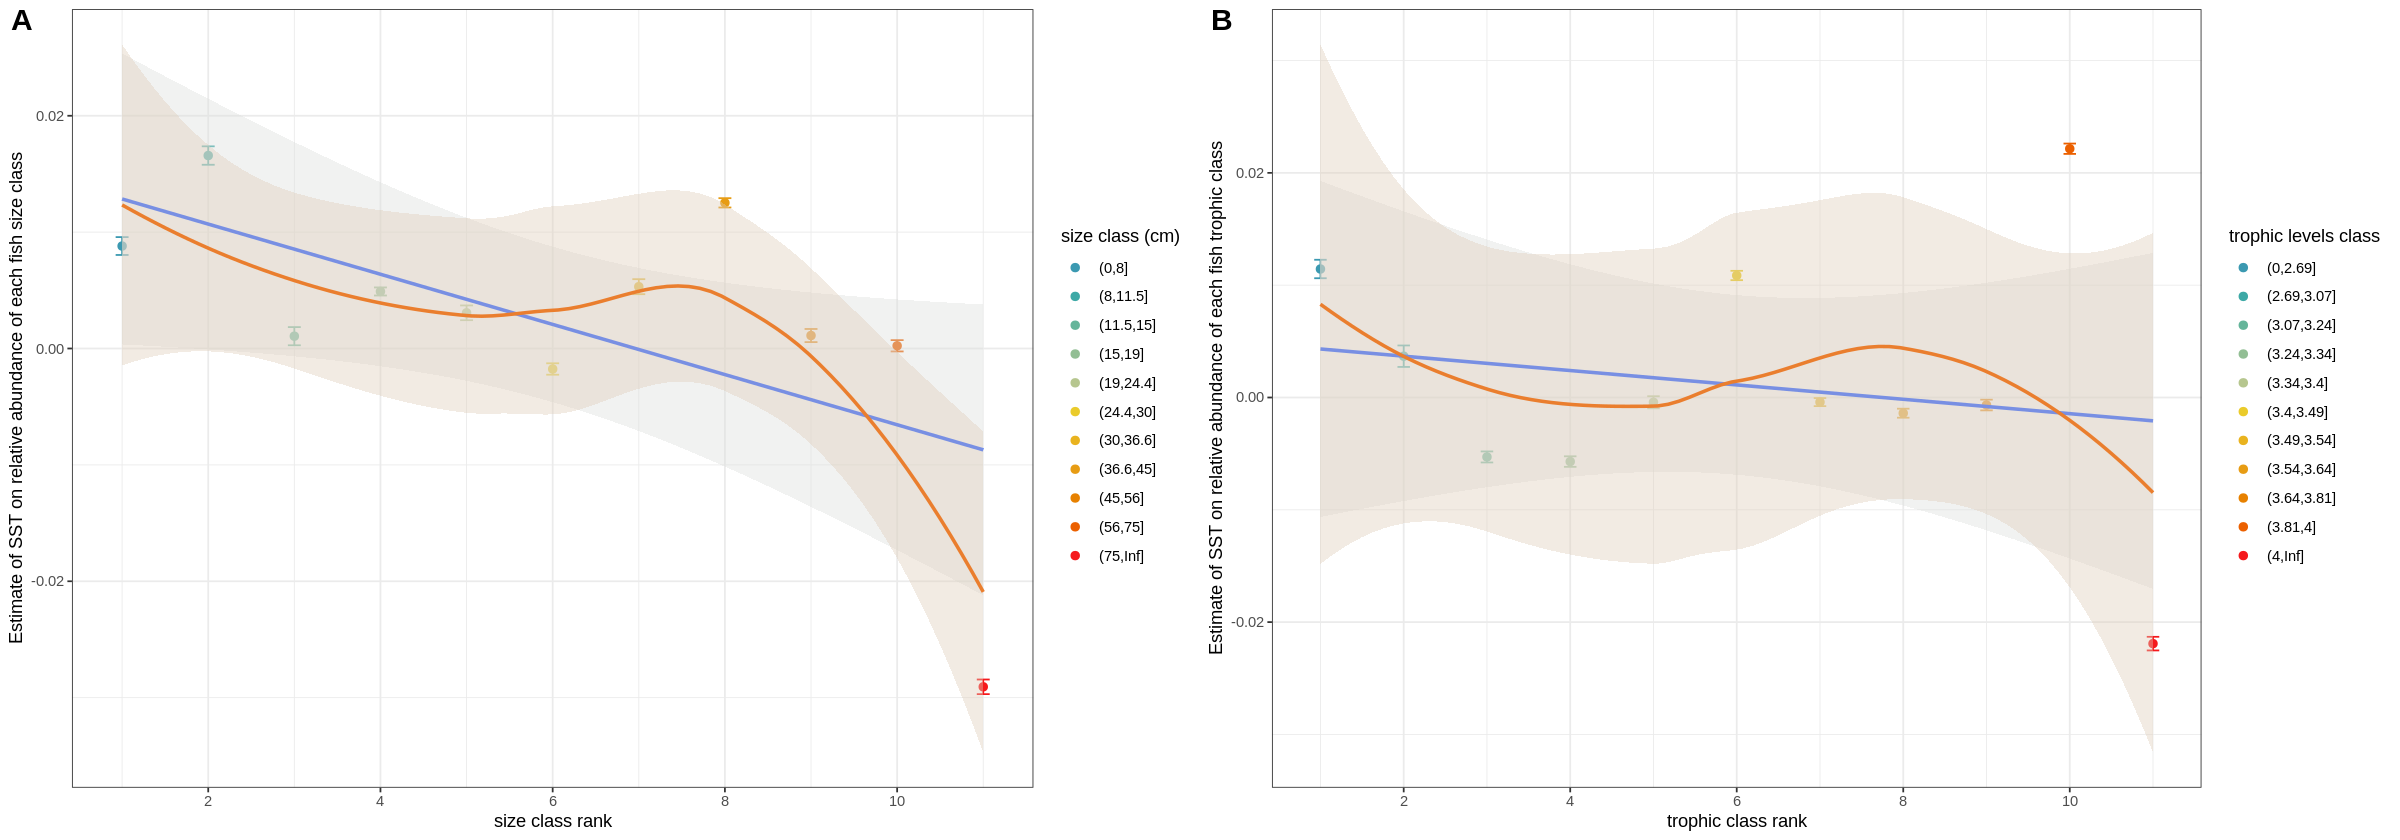

In [245]:
options(repr.plot.width = 20, repr.plot.height = 7)
ggpubr::ggarrange(p_slope, p_slope_troph, ncol = 2, labels = c("A", "B"),
                             font.label = list(size = 18))
ggsave('../output/p_slope_combination.pdf', width = 20, height = 7, units = 'cm', scale = 2.2)

# length and sst trend

In [99]:
lm_eqn <- function(m){
  eq <- substitute(italic(y) == a + b * italic(x)*","~~italic(r)^2~"="~r2~", p ="~p, 
                   list(a = format(unname(coef(m)[1]), digits = 2),
                        b = format(unname(coef(m)[2]), digits = 2),
                        r2 = format(summary(m)$r.squared, digits = 3),
                        p = format(summary(m)$coef[2,4], digits = 2)))
  as.character(as.expression(eq));
}

In [140]:
options(repr.plot.width = 11, repr.plot.height = 7)
sst_fit_length <- lm(estimate.maxLengthTL ~ sst_estimate.maxLengthTL, data = data_selected_maxLengthTL)
summary(fishing_effort_fit_tempPref)
p_sst_length <- ggplot(total_fit, aes(x = sst_estimate.maxLengthTL, y = estimate.maxLengthTL)) + 
    geom_hex(bins = 100) +
    scale_fill_distiller(palette = "Spectral", direction = -1) +
    stat_smooth(method = lm, fill = '#DCDEDD') + 
    labs(fill = 'Number of time series') + 
    xlab('SST trend') + ylab('length trend (cm/yr)')+
                  geom_text(x = -0.12, y = -30, label = lm_eqn(sst_fit_length), size = 7,parse = TRUE) +
    theme_bw() +
    theme(legend.position = c(0.8, 0.1), legend.direction = "horizontal", panel.grid.minor = element_blank())


Call:
lm(formula = estimate.tempPref ~ scale(fishing_effort), data = data_selected_tempPref)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.73026 -0.03449  0.00140  0.04603  2.98108 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)   
(Intercept)           0.005315   0.001865   2.850  0.00438 **
scale(fishing_effort) 0.004414   0.001865   2.367  0.01794 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1942 on 10849 degrees of freedom
Multiple R-squared:  0.0005163,	Adjusted R-squared:  0.0004241 
F-statistic: 5.604 on 1 and 10849 DF,  p-value: 0.01794


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


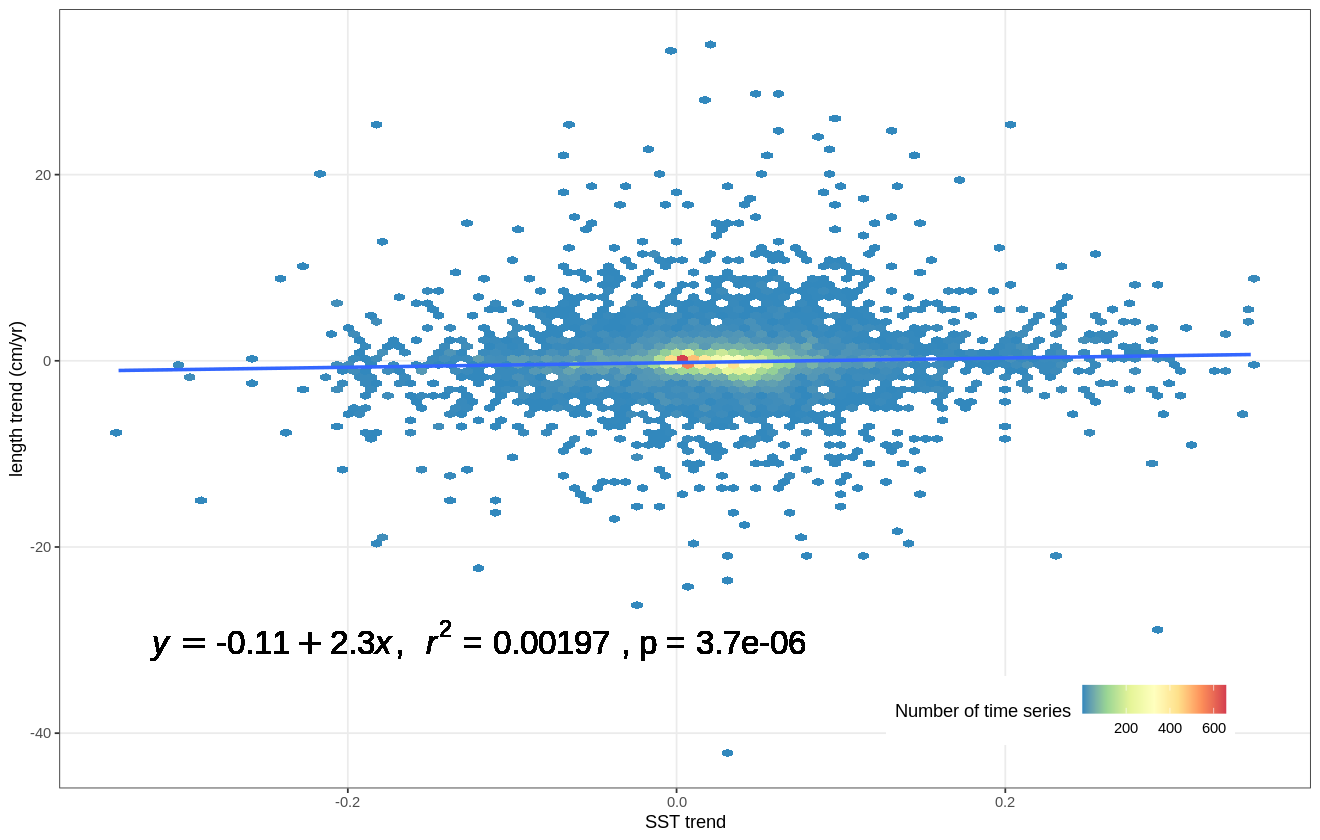

In [141]:
p_sst_length 
ggsave('../output/p_sst_length.tiff', width = 11, height = 7, units = 'cm', scale = 2.5, dpi = 300)

# fishing effort and traits CWM

In [110]:
options(repr.plot.width = 11, repr.plot.height = 7)
fishing_effort_fit_tempPref <- lm(estimate.tempPref ~ scale(fishing_effort), data = data_selected_tempPref)
summary(fishing_effort_fit_tempPref)
p_fishing_effort_tempPref <- ggplot(data_selected_tempPref, aes(x = scale(fishing_effort), y = estimate.tempPref)) + 
    geom_hex(bins = 100) +
    scale_fill_distiller(palette = "Spectral", direction = -1) +
    stat_smooth(method = lm, fill = '#DCDEDD') + 
    labs(fill = 'Number of time series') + 
    xlab('standardized fishing effort') + ylab('tempPref trend (\u00B0C/yr)') +
    theme_bw() +
    theme(legend.position = c(0.8, 0.1), legend.direction = "horizontal", panel.grid.minor = element_blank())
# p_fishing_effort_tempPref


Call:
lm(formula = estimate.tempPref ~ scale(fishing_effort), data = data_selected_tempPref)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.73026 -0.03449  0.00140  0.04603  2.98108 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)   
(Intercept)           0.005315   0.001865   2.850  0.00438 **
scale(fishing_effort) 0.004414   0.001865   2.367  0.01794 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1942 on 10849 degrees of freedom
Multiple R-squared:  0.0005163,	Adjusted R-squared:  0.0004241 
F-statistic: 5.604 on 1 and 10849 DF,  p-value: 0.01794


In [109]:
options(repr.plot.width = 11, repr.plot.height = 7)
fishing_effort_fit_maxLengthTL <- lm(estimate.maxLengthTL ~ scale(fishing_effort), data = data_selected_maxLengthTL)
summary(fishing_effort_fit_maxLengthTL)
p_fishing_effort_maxLengthTL <- ggplot(data_selected_maxLengthTL, aes(x = scale(fishing_effort), y = estimate.maxLengthTL)) + 
    geom_hex(bins = 100) +
    scale_fill_distiller(palette = "Spectral", direction = -1) +
    stat_smooth(method = lm, fill = '#DCDEDD') + 
    labs(fill = 'Number of time series') + 
    xlab('standardized fishing effort') + ylab('length trends (cm/yr)') +
    theme_bw() +
    theme(legend.position = c(0.8, 0.1), legend.direction = "horizontal", panel.grid.minor = element_blank())
# p_fishing_effort_maxLengthTL


Call:
lm(formula = estimate.maxLengthTL ~ scale(fishing_effort), data = data_selected_maxLengthTL)

Residuals:
    Min      1Q  Median      3Q     Max 
-42.163  -0.767  -0.078   0.616  34.244 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)  
(Intercept)           -0.05596    0.02752  -2.034   0.0420 *
scale(fishing_effort)  0.06867    0.02752   2.495   0.0126 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.866 on 10849 degrees of freedom
Multiple R-squared:  0.0005736,	Adjusted R-squared:  0.0004815 
F-statistic: 6.227 on 1 and 10849 DF,  p-value: 0.0126


In [108]:
options(repr.plot.width = 11, repr.plot.height = 7)
fishing_effort_fit_Troph <- lm(estimate.Troph ~ scale(fishing_effort), data = data_selected_Troph) 
summary(fishing_effort_fit_Troph)
p_fishing_effort_Troph <- ggplot(data_selected_Troph, aes(x = scale(fishing_effort), y = estimate.Troph)) + 
    geom_hex(bins = 100) +
    scale_fill_distiller(palette = "Spectral", direction = -1) +
    stat_smooth(method = lm, fill = '#DCDEDD') + 
    labs(fill = 'Number of time series') + 
    xlab('standardized fishing effort') + ylab('trophic trends (/yr)') +
    theme_bw() +
    theme(legend.position = c(0.8, 0.1), legend.direction = "horizontal", panel.grid.minor = element_blank())
# p_fishing_effort_Troph


Call:
lm(formula = estimate.Troph ~ scale(fishing_effort), data = data_selected_Troph)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.220370 -0.009095 -0.000677  0.007995  0.262395 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.0002721  0.0002588   1.051    0.293
scale(fishing_effort) 0.0002584  0.0002588   0.998    0.318

Residual standard error: 0.02696 on 10849 degrees of freedom
Multiple R-squared:  9.188e-05,	Adjusted R-squared:  -2.829e-07 
F-statistic: 0.9969 on 1 and 10849 DF,  p-value: 0.3181


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


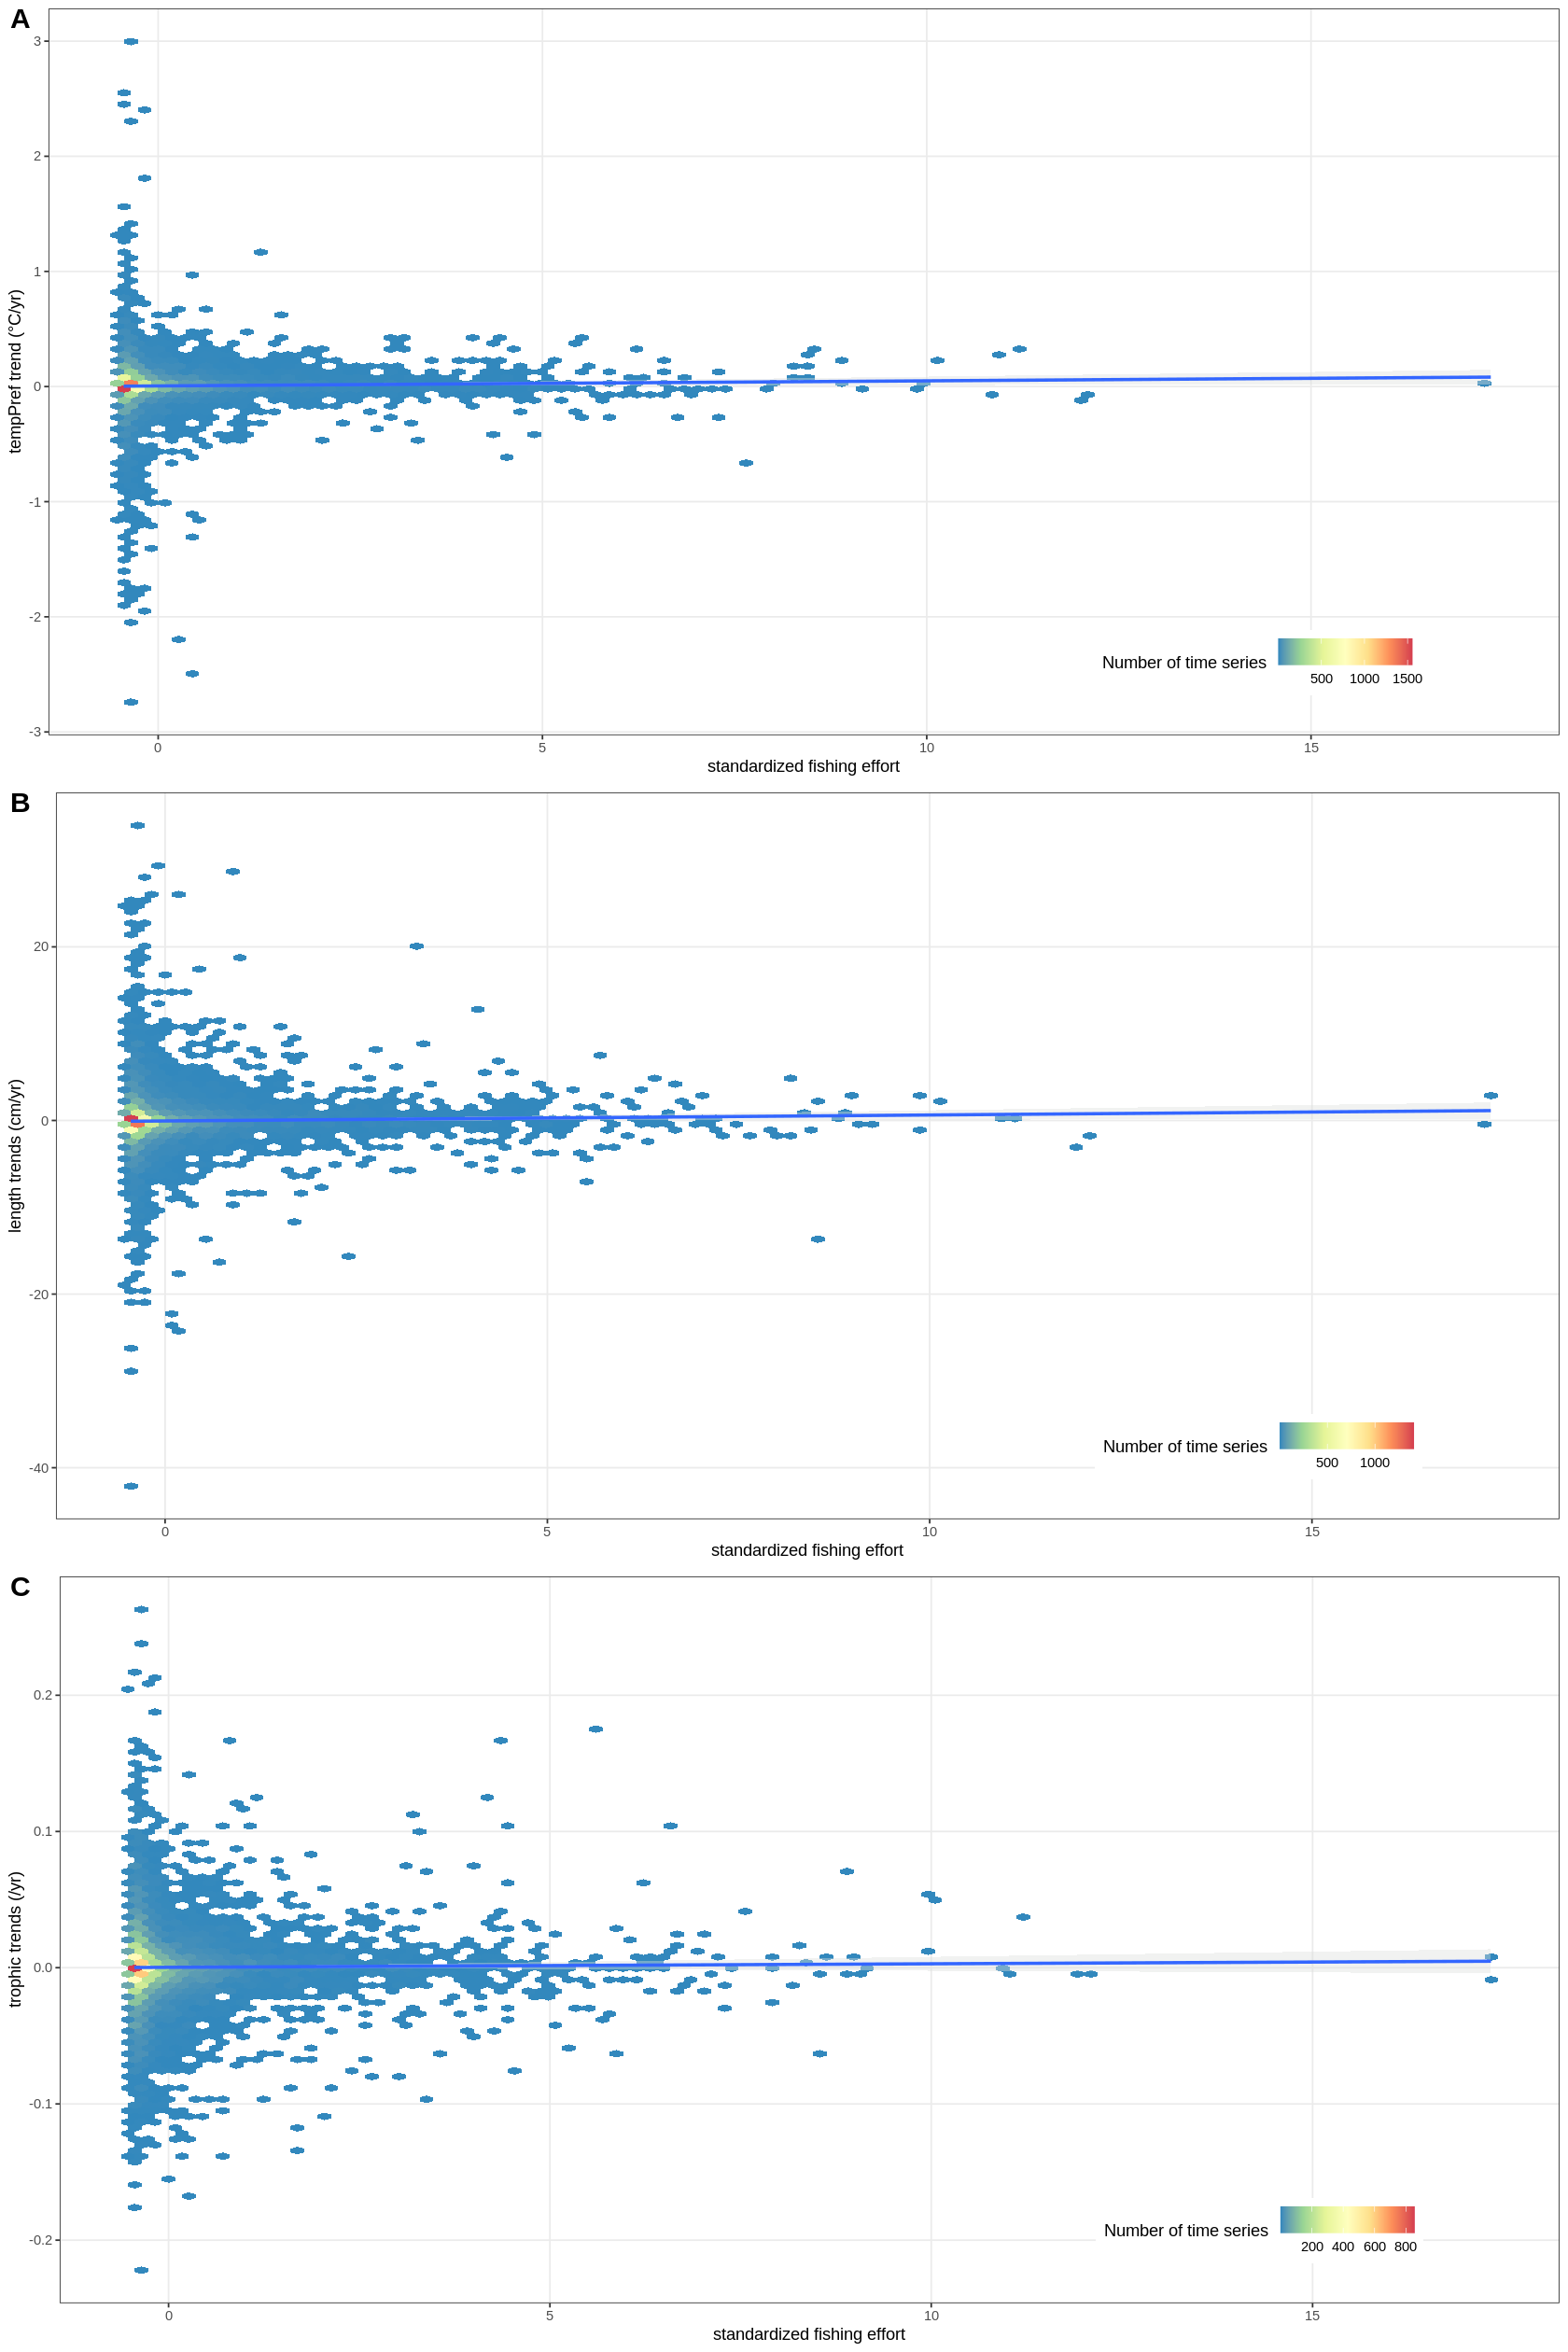

In [107]:
options(repr.plot.width = 14, repr.plot.height = 21)
ggpubr::ggarrange(p_fishing_effort_tempPref, p_fishing_effort_maxLengthTL, p_fishing_effort_Troph, ncol = 1, labels = 'AUTO',
                             font.label = list(size = 18))
ggsave('../output/p_fishing_effort_combination.pdf', width = 14, height = 21, units = 'cm', scale = 2)
options(repr.plot.width = 11, repr.plot.height = 7)